#### Применение нормализации по мини батчам
### Тестируем нормализацию до активации и после и строим графики. mnist

In [153]:
import torch 
import torchvision
import tqdm as notebook_tqdm
import torch.nn as nn
import torch.nn.functional as F

#### Загружаем данные

In [154]:
from torchvision import datasets as dts
from torchvision.transforms import ToTensor 

batch_size_train = 64
batch_size_test = 1000

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

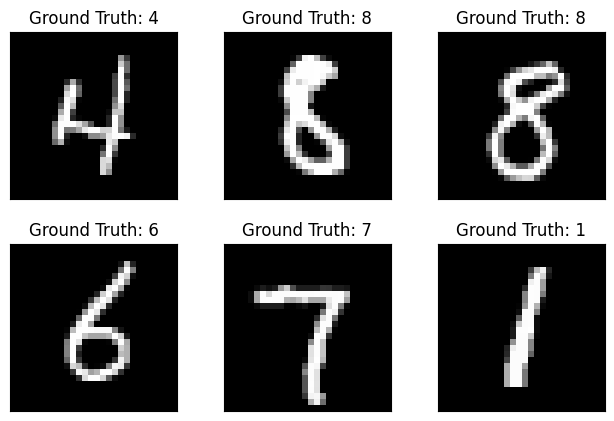

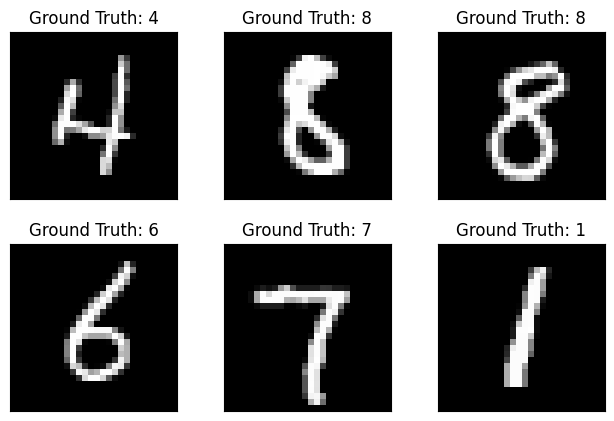

In [155]:
import matplotlib.pyplot as plt

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Нормализация до активации

In [156]:
from math import sqrt

class model_before(nn.Module):
    def __init__(self):
        super( model_before,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 100) 
        self.linear3 = nn.Linear(100, 100) 
        self.linear4 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)

        # добавляем нормализацию
        self.normalization100  = nn.LayerNorm(100)
        self.normalization50  = nn.LayerNorm(50)
        self.normalization  = nn.LayerNorm(28*28)

        nn.init.uniform_(self.linear1.weight, -1/sqrt(5), 1/sqrt(5))
        nn.init.uniform_(self.linear2.weight, -1/sqrt(5), 1/sqrt(5))
        nn.init.uniform_(self.linear3.weight, -1/sqrt(5), 1/sqrt(5))
        nn.init.uniform_(self.linear4.weight, -1/sqrt(5), 1/sqrt(5))
        
        self.tanh = nn.Tanh()

    def forward(self, image):
        a = image.view(-1, 28*28)

        # нормализация до активации
        a = self.normalization(a)
        a = self.tanh(self.linear1(a))

        a = self.normalization100(a)     
        a = self.tanh(self.linear2(a))

        a = self.normalization100(a) 
        a = self.tanh(self.linear3(a))
        
        a = self.normalization100(a)  
        a = self.tanh(self.linear4(a))
        
        a = self.normalization50(a) 
        a = self.final(a)
        return F.log_softmax(a,dim=-1)

model = model_usual()
print(model)

model_usual(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (tanh): Tanh()
)


In [157]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [158]:
def train(model, train_data, batch_idx, optimizer, epoch):

    train_losses = []
    train_counter = []
    epoch_counter = []
    epoch_losses = []

    min_loss_epoch = 100

    count = 0

    for e in range(epoch):
        epoch_counter.append(e)
        min_loss_epoch = 100
        for batch_idx, (data, target) in enumerate(train_data):
    
            # фиксируем количество примеров 
            count+=1
            train_counter.append(count)
    
            optimizer.zero_grad()

            y_pred = model.forward(data)
            loss_vall =  F.nll_loss(y_pred, target)
    

            loss_vall.backward()
            optimizer.step()

            loss_vall = loss_vall.detach().numpy()

            if not (e % 1000 == 0):
                print('Loss - {}, {}/{}'.format(loss_vall, e, epoch))
    
            train_losses.append(loss_vall)
            if loss_vall < min_loss_epoch:
                min_loss_epoch = loss_vall
  
        # запоминаем результат эпохи
        epoch_losses.append(min_loss_epoch)

    return train_counter, train_losses, epoch_counter, epoch_losses

    

In [ ]:
train_losses = []
train_counter = []
epoch_counter = []
epoch_losses = []

train_counter, train_losses, epoch_counter, epoch_losses = train(model, train_loader, batch_idx, optimizer, 3)

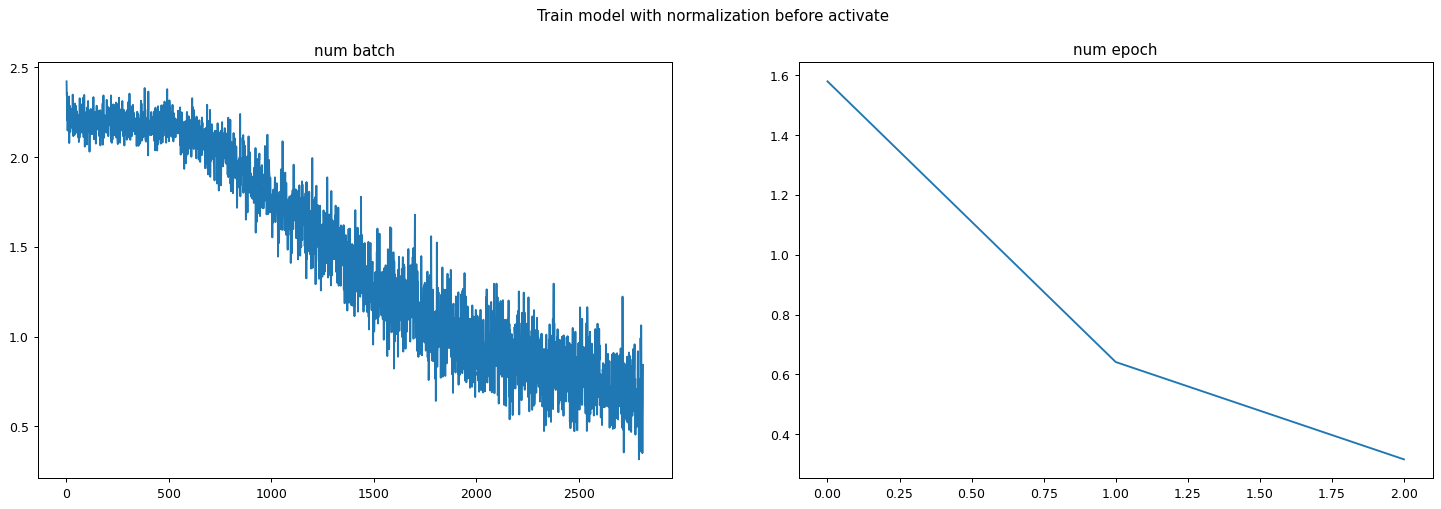

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=90)

fig.suptitle('Train model with normalization before activate')
ax1.set_title('num batch')
ax2.set_title('num epoch')

ax1.plot(train_counter, train_losses)
ax2.plot(epoch_counter, epoch_losses)

In [161]:
def test(model, test_loader):
    model.eval()
    test_losses = []
    test_loss = 0


    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
      
            output = model(data)
      
            test_loss += F.nll_loss(output, target, size_average=False).item()
      
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
      
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
      
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

In [162]:
test(model, test_loader)

/var/folders/tw/0xxcpj311px323qzr54yqgkr0000gn/T/ipykernel_83113/1950759359.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(a)
/Users/kodin/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0683, Accuracy: 7989/10000 (80%)



# Модель с нормализацией после активации

In [163]:
from math import sqrt

class model_after(nn.Module):
    def __init__(self):
        super( model_after,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 100) 
        self.linear3 = nn.Linear(100, 100) 
        self.linear4 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)

        # добавляем нормализацию
        self.normalization100  = nn.LayerNorm(100)
        self.normalization50  = nn.LayerNorm(50)
        self.normalization10  = nn.LayerNorm(10)

        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.linear4.weight)
        
        self.tanh = nn.Tanh()

    def forward(self, image):
        a = image.view(-1, 28*28)

        # нормализация после активации
        a = self.tanh(self.linear1(a))
        a = self.normalization100(a)
   
        a = self.tanh(self.linear2(a))
        a = self.normalization100(a)

        a = self.tanh(self.linear3(a))
        
        a = self.tanh(self.linear4(a))
         
        a = self.final(a)
        
        return F.log_softmax(a,dim=-1)

model_2 = model_after()
print(model_2)

model_after(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (normalization100): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (normalization50): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
  (normalization10): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (tanh): Tanh()
)


In [164]:
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.005)

In [ ]:
train_counter_2, train_losses_2, epoch_counter_2, epoch_losses_2 = train(model_2, train_loader, batch_idx, optimizer_2, 3)

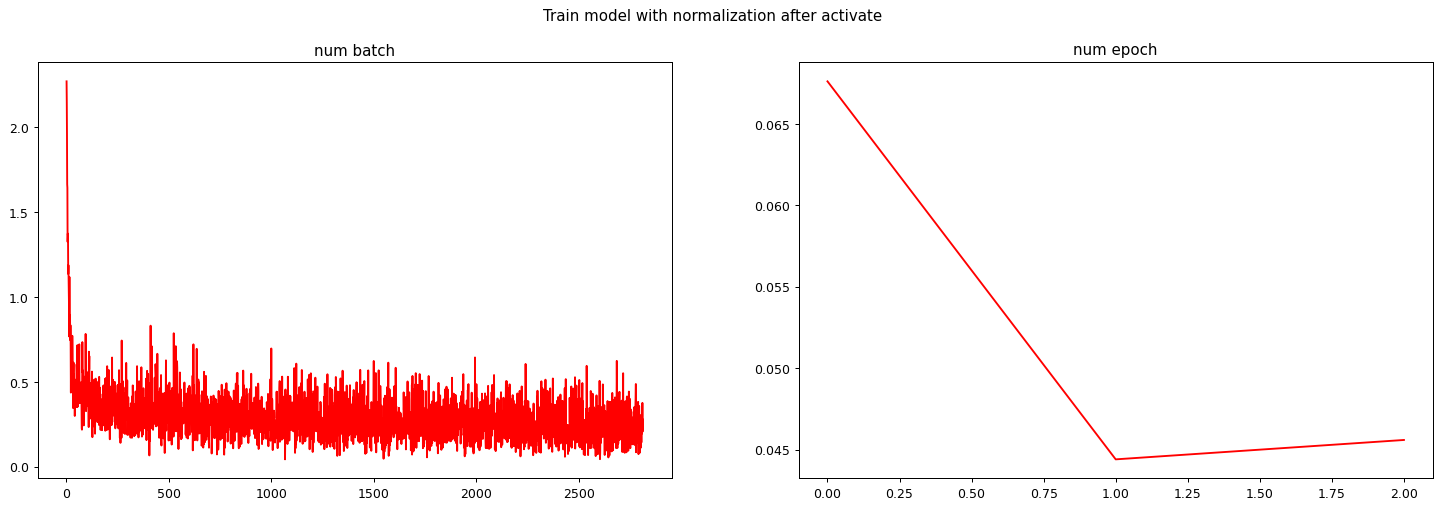

In [166]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=90)

fig.suptitle('Train model with normalization after activate')
ax1.set_title('num batch')
ax2.set_title('num epoch')

ax1.plot(train_counter_2, train_losses_2, color='r')
ax2.plot(epoch_counter_2, epoch_losses_2, color='r')

In [167]:
test(model_2, test_loader)


Test set: Avg. loss: 0.0242, Accuracy: 9225/10000 (92%)



# Обычная модель 

In [168]:

# созадем модель классивфикации изображений
class model_usual(nn.Module):
    def __init__(self):
        super( model_usual,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 100) 
        self.linear3 = nn.Linear(100, 100) 
        self.linear4 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)

        nn.init.uniform_(self.linear1.weight, 0, 1/sqrt(5))
        nn.init.uniform_(self.linear2.weight, 0, 1/sqrt(5))
        nn.init.uniform_(self.linear3.weight, 0, 1/sqrt(5))
        nn.init.uniform_(self.linear4.weight, 0, 1/sqrt(5))
        
        self.tanh = nn.Tanh()

    def forward(self, image):
        a = image.view(-1, 28*28)
        a = self.tanh(self.linear1(a))
        a = self.tanh(self.linear2(a))
        a = self.tanh(self.linear3(a))
        a = self.tanh(self.linear4(a))
        a = self.final(a)
        return F.log_softmax(a)

model_3 = model_usual()
print(model)

model_usual(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (tanh): Tanh()
)


In [169]:
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.005)

In [ ]:
train_counter_3, train_losses_3, epoch_counter_3, epoch_losses_3 = train(model_3, train_loader, batch_idx, optimizer_3, 3)

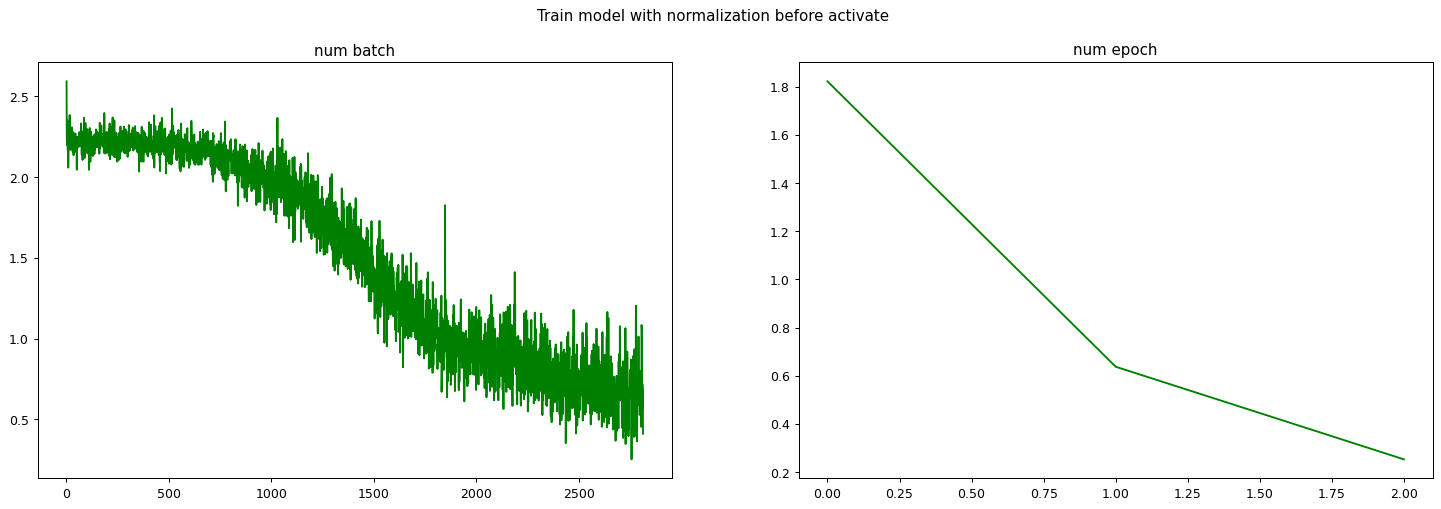

In [172]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=90)

fig.suptitle('Train model with normalization before activate')
ax1.set_title('num batch')
ax2.set_title('num epoch')

ax1.plot(train_counter_3, train_losses_3, color='g')
ax2.plot(epoch_counter_3, epoch_losses_3, color='g')

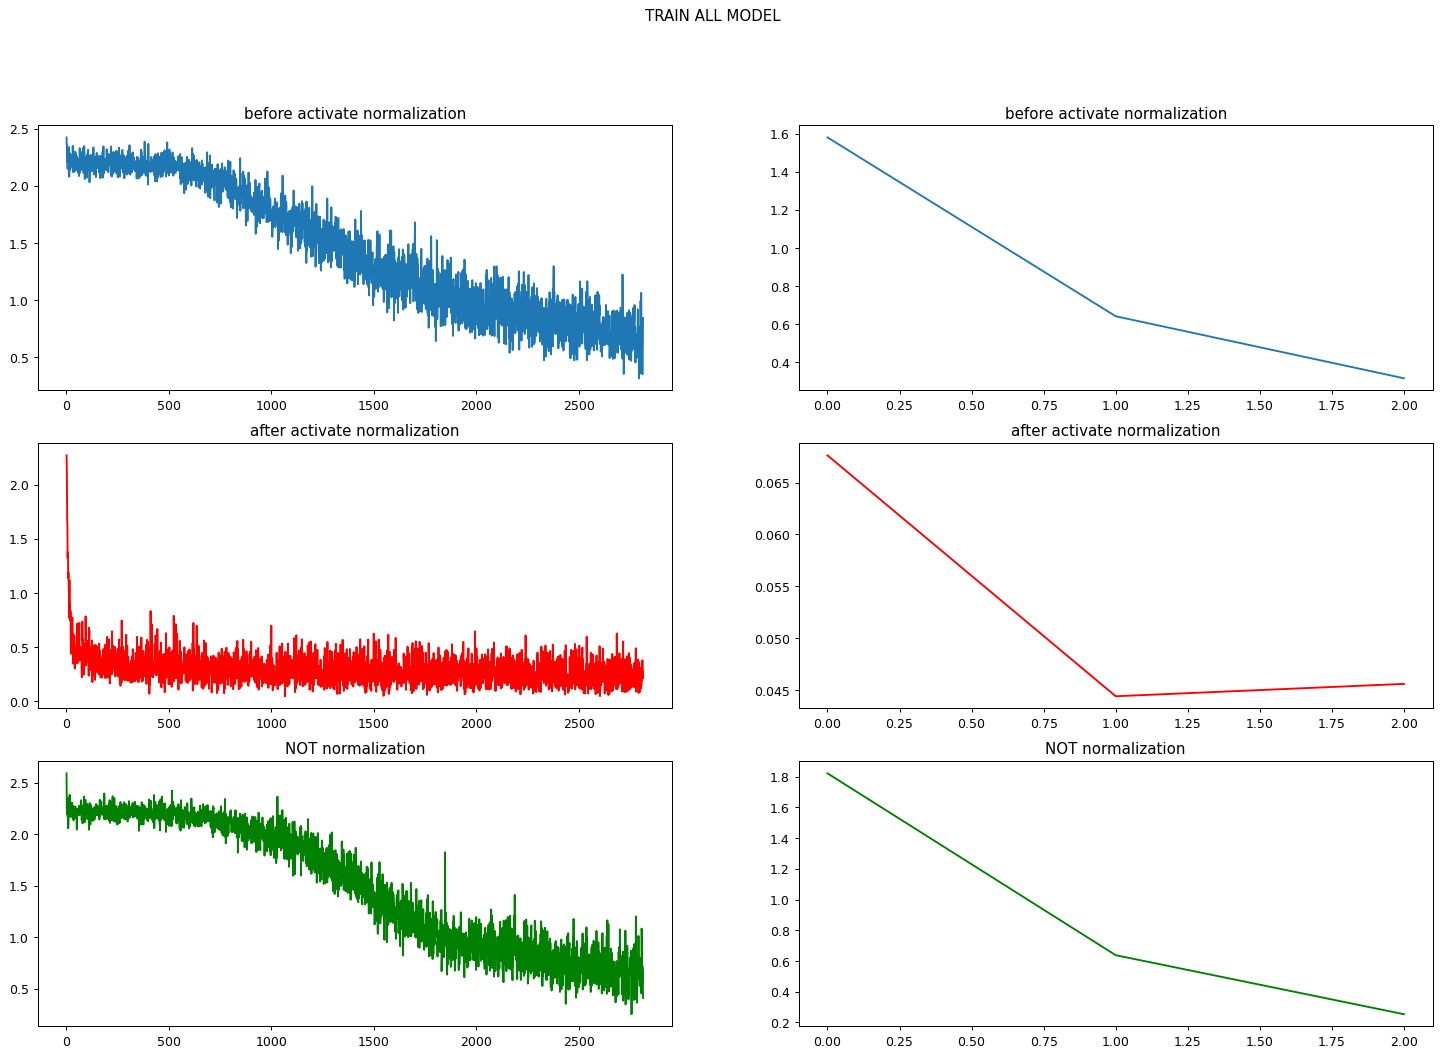

In [199]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 13), dpi=90)

fig.suptitle('TRAIN ALL MODEL')

ax1.set_title('before activate normalization')
ax2.set_title('before activate normalization')

ax3.set_title('after activate normalization')
ax4.set_title('after activate normalization')

ax5.set_title('NOT normalization')
ax6.set_title('NOT normalization')

ax1.plot(train_counter, train_losses)
ax2.plot(epoch_counter, epoch_losses)

ax3.plot(train_counter_2, train_losses_2, color='r')
ax4.plot(epoch_counter_2, epoch_losses_2, color='r')

ax5.plot(train_counter_3, train_losses_3, color='g')
ax6.plot(epoch_counter_3, epoch_losses_3, color='g')


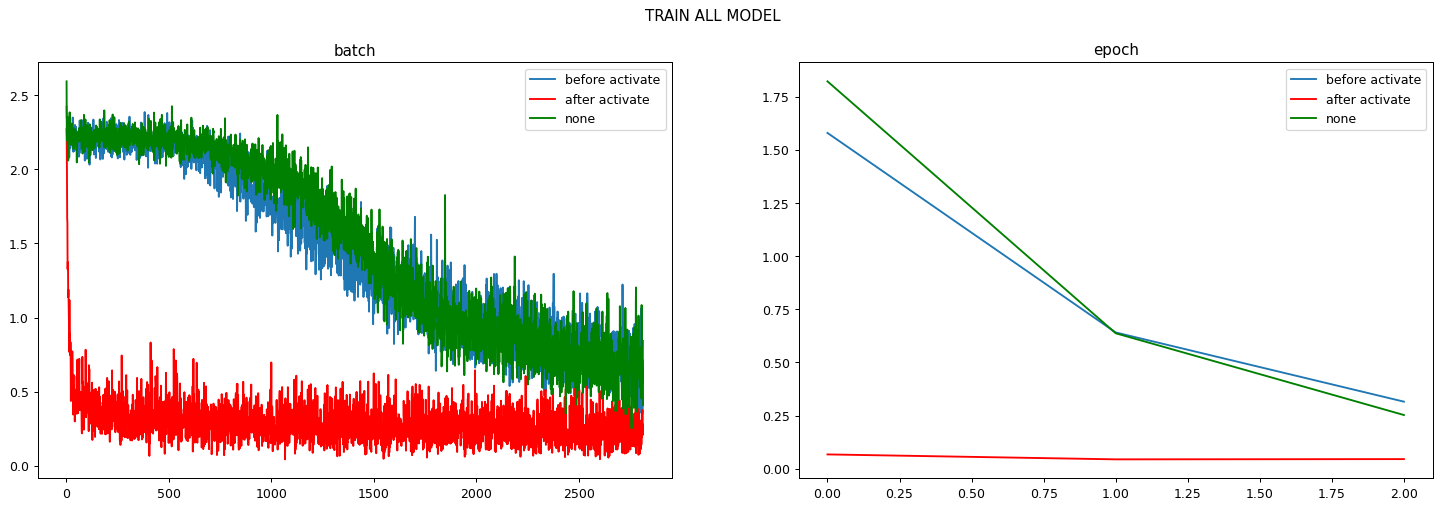

In [200]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 6), dpi=90)

fig.suptitle('TRAIN ALL MODEL')

ax1.set_title('batch')
ax2.set_title('epoch')

ax1.plot(train_counter, train_losses, label = 'before activate')
ax2.plot(epoch_counter, epoch_losses, label = 'before activate')

ax1.plot(train_counter_2, train_losses_2, color='r', label = 'after activate')
ax2.plot(epoch_counter_2, epoch_losses_2, color='r', label = 'after activate')

ax1.plot(train_counter_3, train_losses_3, color='g', label = 'none')
ax2.plot(epoch_counter_3, epoch_losses_3, color='g', label = 'none')

ax1.legend()
ax2.legend()